In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

# Automatic Differentiation

A brief informal introduction to automatic differentiation.

A Neural Network is a function implemented using a composition of small functions. The building blocks of Neural Networks are linear projections and non linear activation functions.

How do we compute the derivative a composite function? Using the chain rule. What pytorch, tensorflow or Jax does is computing this derivatives for any function we specify. So our task is:

1) Specify the function
2) Tell pytorch which derivatives do we want to obtain.

### Basic function

Let's start with the function:

$$
y = (x^2 - 4)^3 + 2
$$

The derivative is

$$
\frac{\partial y}{\partial x} = 3 \cdot (x^2 - 4)^2 \cdot 2 x
$$

something we usually derive implicitely using our knowledge of basic derivatives, such that the derivative of $f(x)^{n}$ is $f(x)^{n-1} \cdot f'(x)$. 

However, when things get complicate we need to specify a way to obtain complex derivatives, and this is where the chain rule comes into place. For functions $f:\mathbb{R} \rightarrow \mathbb{R}$, we can use the one-dimensional chain rule. 

The idea of the chain rule is to express functions as composition of elementary functions from which the derivative is well known. In our example we could break into a small composition of functions.

$$
y = (x^2 - 4)^3 + 2
$$

could be written as:

$$
\begin{split}
t = x^2 \\
u = t - 4 \\
z = u^3 \\
y = z + 2 
\end{split}
$$

Let's start substituting to show it is equivalent. First subsitute $z = u^3$ into $y = z + 2$, yielding $y = u^3 + 2$. Now do the same thing and substitute $u = t - 4$ into $y = u^3 + 2$, yielding: $y = (t - 4)^3 + 2$, and finally subsitute  $t = x^2$ into  $y = (t - 4)^3 + 2$ yielding $y = ( x^2 - 4)^3 + 2$, which is our original function.

When break into small functions, we know that the full derivative can be obtained by multiplying the derivatives of the individual functions. In other words:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x}
$$

Obviously, the derivative of these small functions are usually easier and well known. In fact, the most important thing is that this gives a principle way of obtaining complex derivatives in a structured and well-ordered way. In fact, in this example when you applied the rule $f(x)^{n}$ is $f(x)^{n-1} \cdot f'(x)$, to obtain $\frac{\partial y}{\partial x}$ directly, you are implicitely applying the chain rule without noticing it.

Let's do it:

$$
\begin{split}
&\frac{\partial y}{\partial z} = 1\\
&\frac{\partial z}{\partial u} = 3u^2\\
&\frac{\partial u}{\partial t} = 1\\
&\frac{\partial t}{\partial x} = 2x\\
\end{split}
$$

So applying chain rule we have:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x} = 1 \cdot 3u^2 \cdot 1 \cdot 2x = 3u^2\cdot 2x 
$$

Note that the last is step is to actually have a derivative which is a function of $x$. In other words, we need to replace the value of $u$ in this example. So using a similar proceedure as above we know the steps to perform are: 
1) substitute $t = x^2 $ into $u = t - 4$ to yield  $u = x^2 - 4$, finishing the subsitution.
2) If we place this result back into the derivative, subsituting $u$ by this expression that depends on $x$ we yield:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x} = 1 \cdot 3u^2 \cdot 1 \cdot 2x = 3u^2\cdot 2x = 3(x^2 - 4)^2 \cdot 2x
$$

which happily matches the original derivative we obtained. For multivariate functions $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$, things change a bit but that is a story for another chapter.

## Programming derivatives (numpy)

We can code up this example using numpy, where we code up both forward and backward computational graphs. The forward computational graph is refered to the set of operations that provide $y$ from $x$, i.e. the funciton $y(x) = (x^2 - 4)^3 + 2$, while the backward computatinoal graph is the derivative of $y$ w.r.t $x$, i.e. the function $\frac{\partial y}{\partial x} =  3 \cdot (x^2 - 4)^2 \cdot 2 x$. Both computatinoal graphs can be obtained directly or using chain rule.

In [2]:
def y_of_x(x: np.array):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = (x**2 - 4)**3 + 2
    return y

def y_of_x_from_compositions(x: np.array):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments.

    Using the following composition of functions.

    $$
    \begin{split}
    t = x^2 \\
    u = t - 4 \\
    z = u^3 \\
    y = z + 2 
    \end{split}
    $$
    
    """
    t = x**2
    u = t-4
    z = u**3
    y = z+2
    return y


def partial_y_partial_x(x : np.array):
    """Evaluates the derivative of $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    dy_dx = 3 * (x**2 - 4)**2 * 2 * x
    
    return dy_dx

def partial_y_partial_x_chain_rule(x : np.array):
    """Evaluates the derivative of $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments, using chain rule.
    
    To do so we use composition:

    $$
    \begin{split}
    t = x^2 \\
    u = t - 4 \\
    z = u^3 \\
    y = z + 2 
    \end{split}
    $$

    using partial derivatives:

    $$
    \begin{split}
    \frac{\partial y}{\partial z} = 1
    \frac{\partial z}{\partial u} = 3u^2
    \frac{\partial u}{\partial t} = 1
    \frac{\partial t}{\partial x} = 2x
    \end{split}
    $$
    """
    # we need to go through the function computation, (i.e forward operation) to obtain derivative using chain rule, so that 
    # we can replace u in the derivative.
    t = x**2
    u = t-4
    z = u**3
    y = z+2
    
    dt_dx = 2*x
    du_dt = 1
    dz_du = 3*u**2
    dy_dz = 1

    
    dy_dx = dy_dz * dz_du * du_dt * dt_dx
    
    return dy_dx

Text(0.5, 0.98, 'Using Chain Rule')

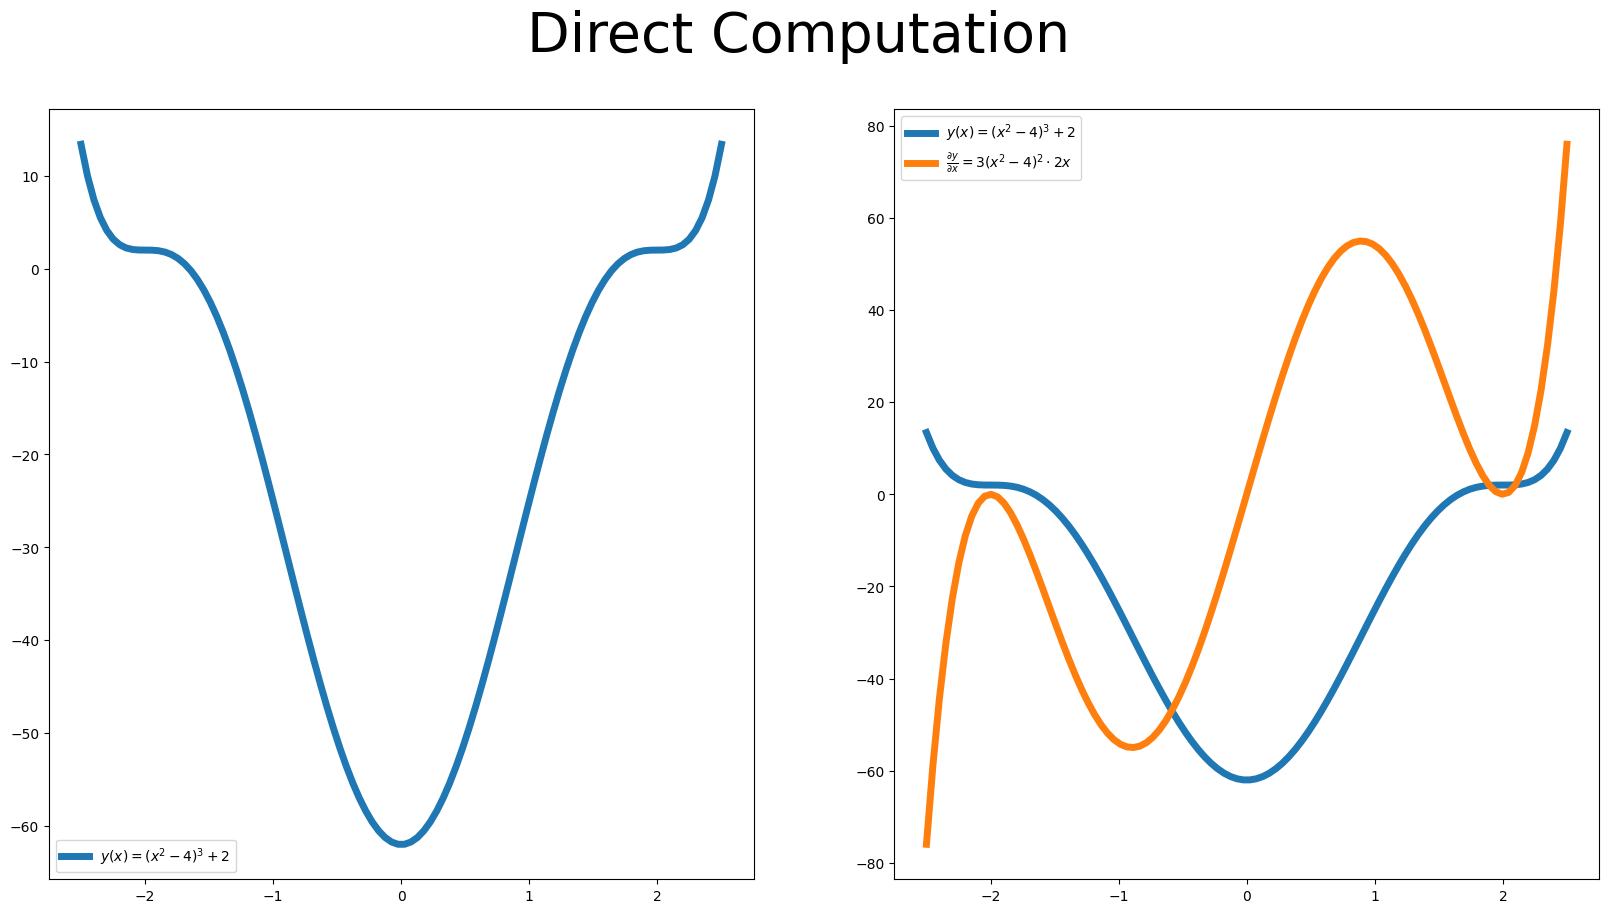

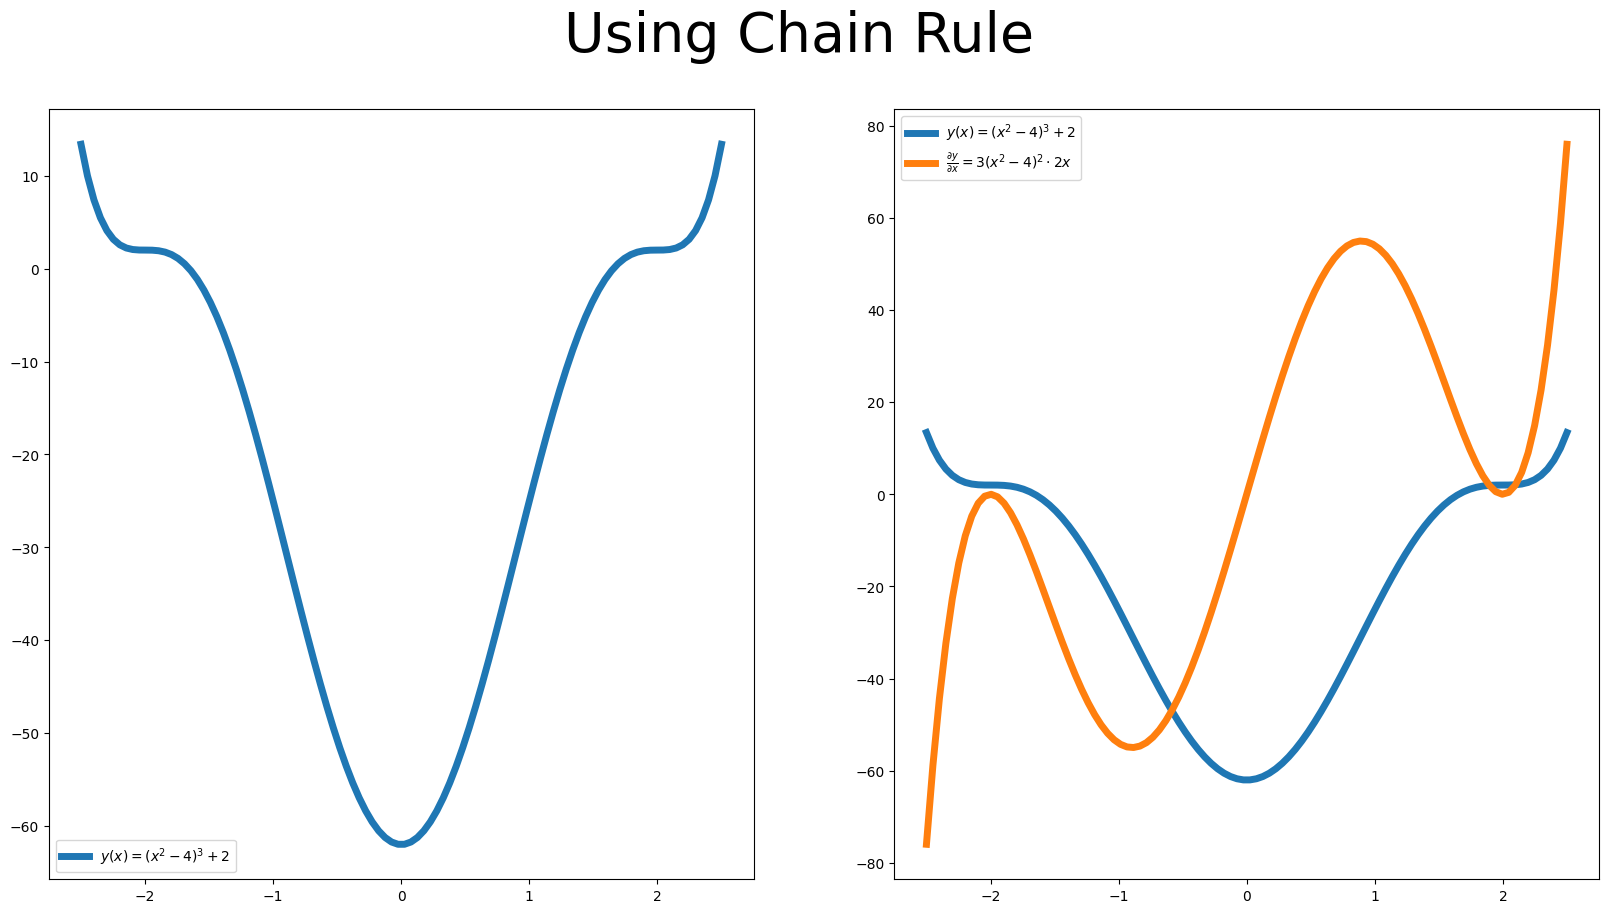

In [3]:
## range over which we want to plot the function
x_min = -2.5
x_max = 2.5
N_points = 100

x = np.linspace(x_min,x_max,N_points)

## Using direct computation
y = y_of_x(x)
dy_dx = partial_y_partial_x(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x, dy_dx, label = r'$\frac{\partial y}{\partial x} = 3(x^2 - 4)^2 \cdot 2x$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Direct Computation", fontsize = 40)

## Using composition of functions and chain rule
y = y_of_x_from_compositions(x)
dy_dx = partial_y_partial_x_chain_rule(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x, dy_dx, label = r'$\frac{\partial y}{\partial x} = 3(x^2 - 4)^2 \cdot 2x$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Using Chain Rule", fontsize = 40)

## Programming derivatives (torch / tensorflow / jax)

What advanced machine learning tools such as torch do to is compute the backward computational graph, from the forward computational graph provide by the user. In other words, tell pytorch which is your target function $y(x)$, through operations, and pytorch will obtain the derivatives automatically, no matter how complex the functions are.

Interestingly, you will notice that the python code is very similar to that used in numpy. The only requirement is to use torch tensors. We also need to tell torch what variables we want the gradient from. 

In [4]:
def y_of_x_torch(x : torch.tensor):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = (x**2 - 4)**3+2
    return y

## with pytorch we can create the associated gradient function by just specifying the computational_graph. This tell us
#  pytorch to provide a funciton that obtains the grad of y_of_x(x) wrt x. Forget about vmap and grad, they are advanced 
#  functions you wont use yet but are useful to me to show what I want to show.
dy_dx_fun = torch.func.vmap( torch.func.grad(y_of_x_torch, argnums = 0) )

Text(0.5, 0.98, 'Computation with Automatic Differentiation')

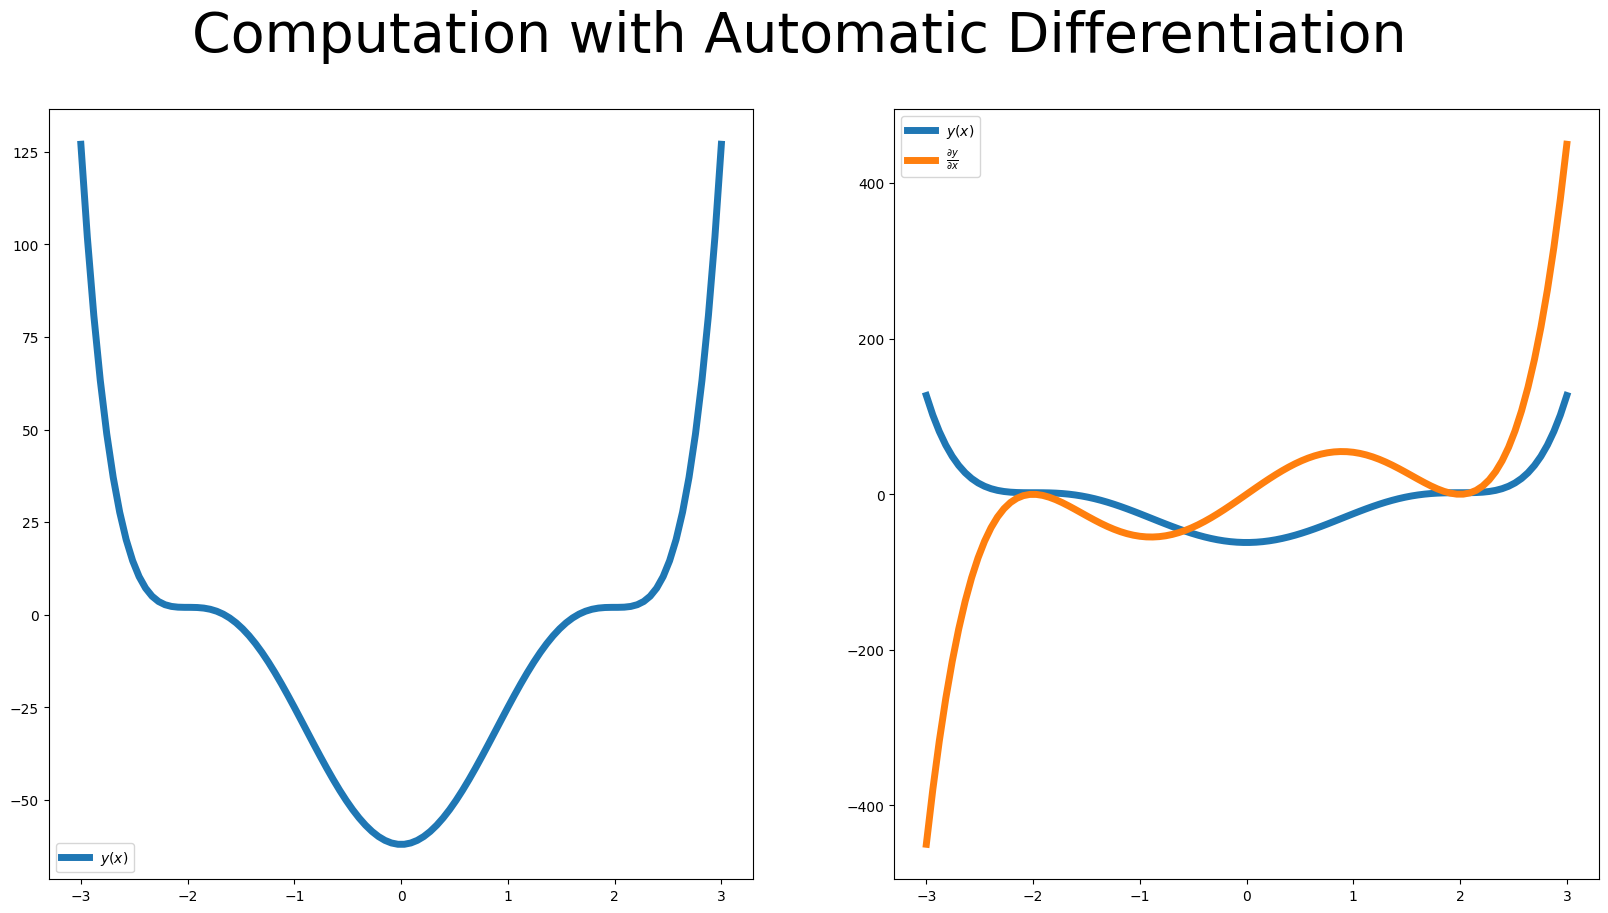

In [5]:
## range over which we want to plot the function
x_min = -3
x_max = 3
N_points = 100

x = np.linspace(x_min,x_max,N_points)

## conver to torch tensor.
x = torch.from_numpy(x)
## Tell pytorch this tensor requires grad so gradient is saved
x.requires_grad = True

## Forward operation: compute y(x)
y = y_of_x(x)

## Backward operation: evaluate the gradient function
dy_dx = dy_dx_fun(x)

## Convert back to numpy vectors. We use detach since vectors require gradients
x = x.detach().numpy()
y = y.detach().numpy()
dy_dx = dy_dx.detach().numpy()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x)$', linewidth = 5)
ax2.plot(x,y, label = '$y(x)$', linewidth = 5)
ax2.plot(x, dy_dx, label = r'$\frac{\partial y}{\partial x}$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Computation with Automatic Differentiation", fontsize = 40)

Obviously, the result is the same as when you computed the derivatives manually. The good point is that now you can change the computational graph as you want, and the way we compute the derivative is let to pytorch. Try and change the computational graph specified by function: 

```python
def y_of_x(x : torch.tensor):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = (x**2 - 4)**3 + 2
    return y
```

to whatever function you want. In this example, you have used pytorch to obtain a computational graph for the gradient function. However, for your use case, you will only need the gradient at a single point. This can be easily obtained using the backward() function from pytorch.

In [6]:
## torch tensor point at which we want the gradient
x = torch.tensor([1.], requires_grad = True)

## evaluate the derivative at that point using torch function
dy_dx = dy_dx_fun(x)

## evaluate the derivative at that point using our numpy function
dy_dx_np = partial_y_partial_x(x.detach().numpy())

## evaluate the derivative at that point using our chain rule numpy function
dy_dx_np_cr = partial_y_partial_x_chain_rule(x.detach().numpy())

## ===========================================
## obtain the derivative at the point directly

# forward through computational graph in pytorch
y = y_of_x_torch(x)
# obtain derivatives wrt to all tensors that require gradient
y.backward()
# observe the gradient
print('Gradient using the gradient function evaluated at a point ', dy_dx.detach().numpy())
print('Gradient using the gradient function using numpy grad function ', dy_dx_np)
print('Gradient using the gradient function using chain rule numpy grad function ', dy_dx_np_cr)
print('Gradient of a tensor using backward on computational graph ', x.grad.detach().numpy())

Gradient using the gradient function evaluated at a point  [54.]
Gradient using the gradient function using numpy grad function  [54.]
Gradient using the gradient function using chain rule numpy grad function  [54.]
Gradient of a tensor using backward on computational graph  [54.]


## Derivatives w.r.t multiple variables

So far so good, we have seen how to obtain the derivative of $y$ wrt $x$, for functions $f : \mathbb{R} \rightarrow \mathbb{R}$. But what if $y$ depends on two variables $x$ and $z$?. Well this is where the multivariate chain rule steps in and I am not going to provide details. However, as you can expect pytorch is able to obtain the derivatives of any function w.r.t any input variable. Just tell it to do it.

To tell it to do it you need to specify:
1) the computational graph.
2) The variables you want pytorch to compute computational graph from.

Importantly, pytorch will implicitely compute and save gradients for all intermediate variables that come from operations that involve at least one tensor that requires gradient. 

Suppose the function.

$$
\begin{split}
u =  2x + z\\
y = (3-u)^2 + z
\end{split}
$$

In [7]:
## First case: Compute derivative wrt x and z
x = torch.tensor([2.], requires_grad = True)
z = torch.tensor([3.], requires_grad = True)

# forward: compute y from inputs x and z
u = 2*x +z
y = (3-u)**2 + z

## Backward: compute gradient wrt tensors that require grad. 
#  u also requires grad since it comes from operations involving tensor that do require grad (x and z).
y.backward()

print('u requires grad: ', u.requires_grad)
print('Gradient of y wrt x: ', x.grad)
print('Gradient of y wrt z: ', z.grad)

## =====================================
## Second case: Compute derivative wrt x
x = torch.tensor([2.], requires_grad = True)
z = torch.tensor([3.], requires_grad = False)

# forward: compute y from inputs x and z
u = 2*x +z
y = (3-u)**2 + z

## Backward: compute gradient wrt tensors that require grad. 
#  u also requires grad since it comes from operations involving tensor that do require grad (x and z).
y.backward()

print('u requires grad: ', u.requires_grad)
print('Gradient of y wrt x: ', x.grad)
print('Gradient of y wrt z: ', z.grad)

## =====================================
## Third case: Compute derivative wrt z
x = torch.tensor([2.], requires_grad = False)
z = torch.tensor([3.], requires_grad = True)

# forward: compute y from inputs x and z
u = 2*x +z
y = (3-u)**2 + z

## Backward: compute gradient wrt tensors that require grad. 
#  u also requires grad since it comes from operations involving tensor that do require grad (x and z).
y.backward()

print('u requires grad: ', u.requires_grad)
print('Gradient of y wrt x: ', x.grad)
print('Gradient of y wrt z: ', z.grad)

u requires grad:  True
Gradient of y wrt x:  tensor([16.])
Gradient of y wrt z:  tensor([9.])
u requires grad:  True
Gradient of y wrt x:  tensor([16.])
Gradient of y wrt z:  None
u requires grad:  True
Gradient of y wrt x:  None
Gradient of y wrt z:  tensor([9.])


## Derivatives w.r.t multiple variables in deep learning

In deep learning, we are interested in computing derivatives of a loss function w.r.t. the parameters that adjust the function being parameterized by the neural network.

Assume your data is given by $N$ points, stored into a matrix $X \in \mathbb{R}^{N\times D_x}$ with each datapoint $x_n \in \mathbb{R}^{D_x}$. For our problem $Dx=1$. You want to compute the regression output $y\in \mathbb{R}$, from the inputs using a two layer's neural network with $512$ neurons per layer, and sigmoid or relu activation function.

The loss function is a squared loss function given by:

$$
\begin{split}
\sum_{n=1}^N (t_n-y(x_n))^2\\
y(x_n) = \text{NNet}(x_n) 
\end{split}
$$

In [8]:
## simulate your data matrix
N = 100 # number of points
Dx = 1 # dimensionality of the problem
Dout = 1 # dimensionality of the output model. Coincides with the dimensionality of the labels
X = torch.from_numpy(np.random.randn(N, Dx)) # random input X data matrix
t = torch.from_numpy(np.random.randn(N, Dout)) # random input t data vector

## define neural network parameters
num_neurons = 512

W1 = torch.from_numpy(np.random.randn(Dx,num_neurons))
W1.requires_grad = True
b1 = torch.zeros((num_neurons,))
b1.requires_grad = True

W2 = torch.from_numpy(np.random.randn(num_neurons,num_neurons))
W2.requires_grad = True
b2 = torch.zeros((num_neurons,))
b2.requires_grad = True

W3 = torch.from_numpy(np.random.randn(num_neurons,Dout))
W3.requires_grad = True
b3 = torch.zeros((Dout,))
b3.requires_grad = True

## =======
## forward
# layer 1
Z1 = torch.sigmoid(torch.mm(X,W1) + b1)
# layer 2
Z2 = torch.sigmoid(torch.mm(Z1,W2) + b2)
# output layer
y = torch.mm(Z2,W3) + b3
# compute loss function
C = torch.sum((t-y)**2)

## ==============
## Show gradients
print(W1.grad)
print(b1.grad)
print(W2.grad)
print(b2.grad)
print(W3.grad)
print(b3.grad)

## ========
## backward
C.backward()

## ==============
## Show gradients
# print(W1.grad)
# print(b1.grad)
# print(W2.grad)
# print(b2.grad)
# print(W3.grad)
print(b3.grad)

None
None
None
None
None
None
tensor([-149.1379])


Wrap now our computational graph into;
* initialization_function: initializes the parameters of the network
* forward function: computes the output given the inputs
* loss function: compute the loss

In [9]:
## network initialization
def initialize_network(num_neurons, Dx, Dout):
    torch.manual_seed(seed = 1)
    
    W1 = torch.from_numpy(np.random.randn(Dx,num_neurons))
    W1.requires_grad = True
    b1 = torch.zeros((num_neurons,))
    b1.requires_grad = True
    
    W2 = torch.from_numpy(np.random.randn(num_neurons,num_neurons))
    W2.requires_grad = True
    b2 = torch.zeros((num_neurons,))
    b2.requires_grad = True
    
    W3 = torch.from_numpy(np.random.randn(num_neurons,Dout))
    W3.requires_grad = True
    b3 = torch.zeros((Dout,))
    b3.requires_grad = True

    # save parameters
    parameters = {
        'l1' : {
            'W' : W1,
            'b': b1
        },
        'l2' : {
            'W' : W2,
            'b': b2
        },
        'lo' : {
            'W' : W3,
            'b': b3
        }    
    }
    
    return parameters 

## network forward
def forward(X,parameters):
    W1 = parameters['l1']['W']
    b1 = parameters['l1']['b']
    W2 = parameters['l2']['W']
    b2 = parameters['l2']['b']
    W3 = parameters['lo']['W']
    b3 = parameters['lo']['b']
    
    # layer 1
    Z1 = torch.sigmoid(torch.mm(X,W1) + b1)
    # layer 2
    Z2 = torch.sigmoid(torch.mm(Z1,W2) + b2)
    # output layer
    y = torch.mm(Z2,W3) + b3

    return y

## loss function computation per datapoint
def loss_function(t,y):
    C = (t-y)**2
    return C

## loss function computation by summing up
def loss_function_acc(C, dim = None):
    return torch.sum(C, dim)

def optimization_step(parameters, lr):
    # Note: returning is really not necessary since dictionaries are passed as pointers. Also saving back 
    # parameters to the parameters dictionary since torch tensors are also pointers.    
    
    ## extract parameters
    W1 = parameters['l1']['W']
    b1 = parameters['l1']['b']
    W2 = parameters['l2']['W']
    b2 = parameters['l2']['b']
    W3 = parameters['lo']['W']
    b3 = parameters['lo']['b']

    ## step on gradient descent
    W1.data = W1.data - lr * W1.grad
    b1.data = b1.data - lr * b1.grad
    W2.data = W2.data - lr * W2.grad
    b2.data = b2.data - lr * b2.grad
    W3.data = W3.data - lr * W3.grad
    b3.data = b3.data - lr * b3.grad

    ## reset gradient saved
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()
    
    ## save back parameters
    parameters['l1']['W'] = W1
    parameters['l1']['b'] = b1
    parameters['l2']['W'] = W2
    parameters['l2']['b'] = b2
    parameters['lo']['W'] = W3
    parameters['lo']['b'] = b3
    
    return parameters
    

Let's train our neural networks on our usual problem using gradient descent but computing the derivatives directly using pytorch

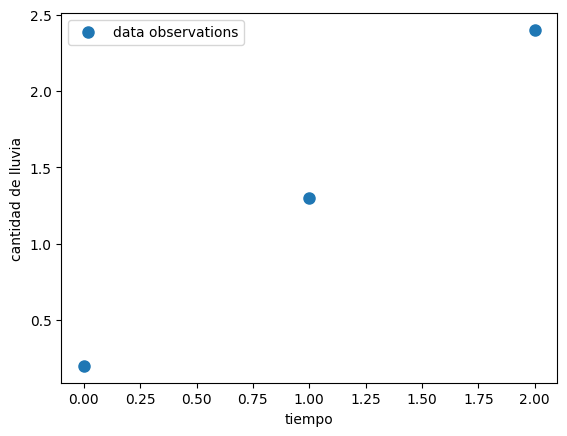

In [10]:
## =============== ##
## Define our data ##
## =============== ##

# input to our model. Represents time in seconds
x_data = np.array([0.0,1.0,2.0]).reshape(3,1)
# outputs associated to each input. Represents cantidad de lluvia in mm^3
t_data = np.array([0.2,1.3,2.4]).reshape(3,1)

# convert to torch tensors
x_data = torch.from_numpy(x_data)
t_data = torch.from_numpy(t_data)

## display
plt.plot(x_data,t_data,'o', markersize = 8, label = 'data observations')
plt.xlabel('tiempo')
plt.ylabel('cantidad de lluvia')
plt.legend()

In [11]:
%matplotlib tk

In [12]:
## ====================================== ##
## ========== Gradient Descent ========== ##
## ====================================== ##

## number of points in the domain used to plot the functions 
N_points_domain = 100
x_range = torch.from_numpy(np.linspace(-1,4, N_points_domain).reshape((N_points_domain,1)))

## specify our computational graph
Dx = 1
D_out = 1
num_neurons = 512

# plot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Initialize network parameters
parameters = initialize_network(num_neurons, Dx, D_out)

## gradient descent parameters
lr = 0.00025
epochs = 100
epochs_range = [] # to display
loss_over_training = [] # loss over training

for e in range(epochs):

    ## add new epoch computed
    epochs_range.append(e)
    
    ## compute function at current parameter value
    with torch.no_grad(): # tell pytorch to not trace forward computational graph
        function = forward(x_range, parameters)

    ## compute predictions at current parameter value: forward
    y_pred = forward(x_data, parameters)

    ## compute loss at current parameter value
    loss = loss_function(t_data,y_pred)
    loss_acc = loss_function_acc(loss)
    loss_over_training.append(loss_acc.item())

    ## compute gradients through chain rule: backward
    loss_acc.backward()

    ## update parameterse
    optimization_step(parameters, lr)

    ## ============= ##
    ## ============= ##
    ## START DRAWING ##
    ## ============= ##
    ## ============= ##
    # Clear previous data
    ax1.clear()  
    ax2.clear()

    ## prepare some variables to plot
    x_data_plot = torch.squeeze(x_data).detach().numpy()
    t_data_plot = torch.squeeze(t_data).detach().numpy()
    y_pred_plot = torch.squeeze(y_pred).detach().numpy()
    loss_plot = torch.squeeze(loss).detach().numpy()

    ## ================ ##
    ## function picture ##
    ax2.plot(x_range, function, color = 'C1', label = 'function: y = w*x')
    ax2.plot(x_data, t_data,'o', markersize = 8, label = 'data observations')

    ## plot squared loss associated at each point and draw line between dots to highliht what the loss measures
    for idx, (xi, ti, yi, sl) in enumerate(zip(x_data_plot,t_data_plot,y_pred_plot,loss_plot)):
        if idx == 0:
            ax2.plot(xi,yi, 'x', color = 'C1', label = 'network prediction')
        else:
            ax2.plot(xi,yi, 'x', color = 'C1')
        ax2.plot([xi,xi], [ti, yi], '--',color = f"C1", alpha = 0.5)
        ax2.text(xi, yi, f'{sl:.2f}', fontsize=12, va='top', color = f"C1" ) 

    ax2.text(1, 33, f"Iteration {e}, squared loss = {loss_acc:.2f}", fontsize=12, va='bottom', color = f"C1" ) 
    ax2.set_xlabel('tiempo')
    ax2.set_ylabel('cantidad de lluvia')
    ax2.set_ylim([-10,30])
    ax2.legend()

    ## draw
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    ## ===================== ##
    ## loss function picture ##
    
    ## 0. label and axis limits
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Loss')
    ax1.set_ylim([-200,900])

    ## 1. display loss function
    ax1.plot(epochs_range, loss_over_training, color = 'C0', label = 'loss')
    ax1.set_xlim([0, epochs])
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.5)

